# Fitting tomography datas

Jiawei Qiu, 2023.8.16.

It is easy to do a state tomography.

Consider we have a state, say single qubit |0> state, whose density matrix is `[[1,0], [0,0]]`.

To do the state tomography, one need to measure the state along some different basis. 
Or in practice, measure p0, p1 after applying I, X/2, Y/2 pulses. 

Then we can fit the density matrix.

In [1]:
from labcodes import tomo
probs = [1, 0, .5, .5, .5, .5]  # i_p0, i_p1, x_p0, x_p1, y_p0, y_p1
rho_fit = tomo.qst(probs)

import numpy as np
np.allclose(rho_fit, [[1,0], [0,0]], atol=1e-5)

(CVXPY) Aug 16 05:16:50 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: 找不到指定的模块。')


True

To do process tomography, one need to measure the system state after apply the process to several known initial states.

In practice, we usually prepare system by applying I, X/2, Y/2 or X pulses on |0> state. 
And fit the outcome states after let system undergoing the process. 

Providing the input and output density matrices, we can now characterize the process with a matrix.
But we need a basis to write down the matrix, usually it is the Pauli's, i.e. $I$, $\sigma_X$, $\sigma_Y$, $\sigma_Z$

Here let's consider a trivial process: identity.

In [2]:
rho_in = [
    [[1, 0], [0, 0]],  # 0
    [[0.5, 0.5j], [-0.5j, 0.5]],  # x
    [[0.5, 0.5], [0.5, 0.5]],  # y
    [[0, 0], [0, 1]],  # 1
]
rho_in = [np.array(rho) for rho in rho_in]
rho_out = rho_in
chi = tomo.qpt(rho_out, rho_in)
chi_ideal = np.zeros((4,4))
chi_ideal[0,0] = 1
np.allclose(chi, chi_ideal, atol=1e-5)

True

It is a bit annoying constructing the ideal density matrix everytime, especially for multi-qubit system.

So actually we don't need to provide rho_in to use the function, just like

In [3]:
chi = tomo.qpt(rho_out)
np.allclose(chi, chi_ideal, atol=1e-5)

True

It is not magic but simply having the common choice of initial states build-in.
You can read the details in the function documentation.

Besides, this works for multi-qubit case, we can infer the number of qubits from input.

In [4]:
help(tomo.qpt)

Help on function qpt in module labcodes.tomo:

qpt(rho_out: list[numpy.matrix], rho_in: Union[list[numpy.matrix], Literal['0xy1']] = '0xy1', basis: Union[list[numpy.matrix], Literal['sigma', 'raise-lower']] = 'sigma', fit_method: Literal['cvx', 'lstsq'] = 'cvx')
    Find the process matrix given the input and output density matrices.
    
    Example:
    >>> rho_out = [Ypi @ rho @ Ypi.T.conj() for rho in get_rho_in("0xy1", 1)]
    >>> chi = qpt(rho_out)
    >>> chi_ideal = np.zeros((4,4))
    >>> chi_ideal[2,2] = 1
    >>> np.allclose(chi, chi_ideal, atol=1e-5)
    True



Above are all you need to know for using the module.

Besides, we offers more useful functions in the module. Such as calculating the ideal measured probabilities in tomo experiments from a arbitrary density matrix, or calculating the output states of a given process matrix chi from a arbitrary input state, and etc.

Check them out yourself.

In [5]:
help(tomo)

Help on module labcodes.tomo in labcodes:

NAME
    labcodes.tomo - Module for processing data of Quantum State Tomography (QST) and Quantum Processs Tomography (QPT)

DESCRIPTION
    Adapted from pyle_tomo and the matlab code from Youpeng Zhong.
    
    
    # Explanation of QST
    
    For QST, one should measure qubit state probabilities after applying different `tomo_ops`,
    then the density matrix is obtained by
    
    `rho = qst(probs, tomo_ops="ixy")`,
    
    where `tomo_ops` are list of matrices of the operations applied before measurement.
    Typically it is [I, X/2, Y/2]. You can pass `tomo_ops="ixy"` to use it.
    `rho` is reconstructed on basis of |0> and |1>.
    
    For example, in 1-qubit case, the input probs should be like:
    `probs = [i_p0, i_p1, x_p0, x_p1, y_p0, y_p1]`
    
    In 2-qubit case, it is:
    ```
    probs = [ii_p00, ii_p01, ii_p10, ii_p11,
             ix_p00, ix_p01, ix_p10, ix_p11,
             iy_p00, iy_p01, iy_p10, iy_p11,
           

# Accuracy and tests

Still here? Maybe you are warry about the accuracy of our functions.
You can test them with more examples, just like

In [6]:
rho_s0 = tomo.qst([1, 0, .5, .5, .5, .5])
rho_sx = tomo.qst([.5, .5, 0, 1, .5, .5])
rho_sy = tomo.qst([.5, .5, .5, .5, 0, 1])
rho_s1 = tomo.qst([0, 1, .5, .5, .5, .5])

np.allclose([rho_s0, rho_sx, rho_sy, rho_s1], rho_in, atol=1e-5)

True

And more tests

In [7]:
rho_ideal = tomo.get_rho_in('0xy1', 2)
probs = [tomo.get_probs(rho) for rho in rho_ideal]
rho_fit = [tomo.qst(p) for p in probs]
np.allclose([tomo.fidelity(rho, ideal) for rho, ideal in zip(rho_fit, rho_ideal)], 1)

True

In [8]:
rho_ideal = [tomo.random_density_matrix(4) for _ in range(10)]
probs = [tomo.get_probs(rho) for rho in rho_ideal]
rho_fit = [tomo.qst(p, fit_method="lstsq") for p in probs]
np.allclose([tomo.fidelity(rho, ideal) for rho, ideal in zip(rho_fit, rho_ideal)], 1)

True

Also you can check the physical constraints of the matrices.

In [9]:
is_unity = np.allclose([np.trace(rho) for rho in rho_fit], 1)
is_hermite = np.allclose([np.linalg.norm(rho - rho.T.conj()) for rho in rho_fit], 0)
is_positive_semidefinite = np.all([np.linalg.eigvals(rho).min() >= 0 for rho in rho_fit])

is_unity and is_hermite and is_positive_semidefinite

True

Actually we have checked that before returning, see below.

In [10]:
orig_val = tomo.check_tolerance
print('default threshold:', tomo.check_tolerance)
tomo.check_tolerance = -1

_ = tomo.qst([1, 0, .5, .5, .5, .5])
tomo.check_tolerance = orig_val

mat is not unit trace: tr(mat) = (1.0000000309732928+0j)
mat is not hermitian: max(abs(mat - mat.dagger())) = 0.0
mat is not positive: eigvals include [-9.36318256e-06]


default threshold: 1e-05


We have include the a complete test function in the module, including multi-qubit state and process tomography.

c:\Users\iqse1\miniconda3\envs\siqalab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 400/400 [00:16<00:00, 24.91it/s] 


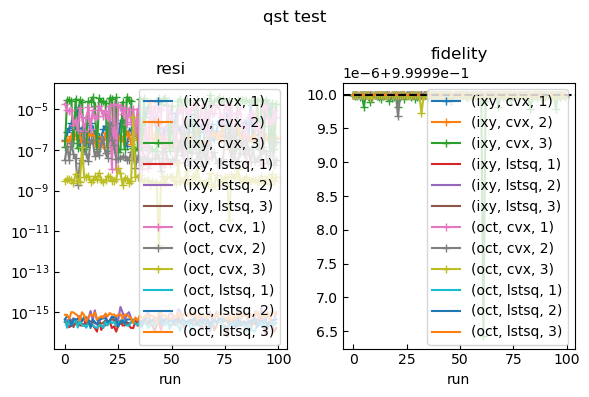

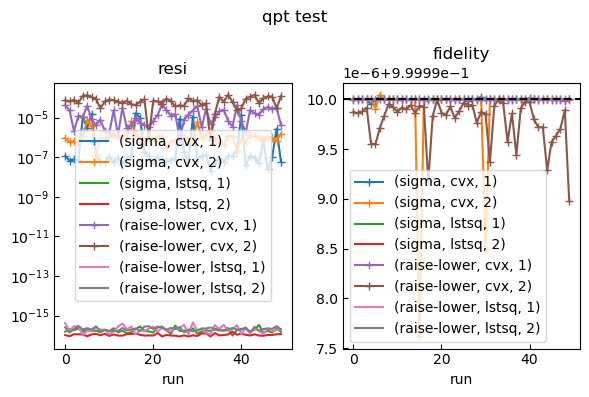

In [11]:
df_qst = tomo.test_qst()
df_qpt = tomo.test_qpt()